# Analysis of Neutron Diffraction Data

This notebook can be found in the github repo:
https://github.com/gcsantucci/SMC_DataChallenge_Diffraction/blob/master/figs/analysis.md

This is part of a data science challenge promoted by Oak Ridge National Lab. See more here:

https://smc-datachallenge.ornl.gov/

This particular challenge is described in more details here:

https://smc-datachallenge.ornl.gov/2017/challenge-4/

The main idea of this challenge is to be able to detect phase transitions in a material by looking at curves of intensity as a function of distance (characteristical spacing of the material).
The strategy is to look for peaks of intensity at a given temperature, count the number of peaks and characterize them (area, center and width). Then, by doing the same analysis at the adjacent temperatue, we can study if the peak structure changed due to a phase transition.

In [1]:
%matplotlib inline  
import os
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, pylab
from scipy.optimize import curve_fit
from scipy import stats
from visuals import *
from peaks import *

Change file location accordingly:

In [2]:
path = '/Users/santucci/Dropbox/DataScience/SMC_DataChallenge17'
infile = 'data/Powder_Diffraction.nxs'
infile = os.path.join(path, infile)

Read the file and inspect it:

In [3]:
f = h5py.File(infile, 'r')

In [4]:
for i in f:
    print(i)

entry


In [5]:
for i in f['entry']:
    print(i)

data


In [6]:
for i in f['entry']['data']:
    print(i)

Q
dspacing
intensity
temperature


Let's define the necessary arrays that will be used in our analysis:
- ds: Since dspacing (Angstrom) is an array containing the bin edges, we can define a new array contaning the bin centers to plot our data.
- I: The intensities 2d-array, containing all the intensity values for a given temperature T: I[T][i]
- T: The corresponding temperature (Kelvin) array.

In [7]:
ds = np.array(f['entry']['data']['dspacing'])
ds = (ds[:-1] + ds[1:]) / 2
I = np.array(f['entry']['data']['intensity'])
T = np.array(f['entry']['data']['temperature'])
f.close()   # closing the file, since we got all the data!

### Inspecting the data:

Let's look at a few curves I(d) for random values of temperature to get familiarized with the data:

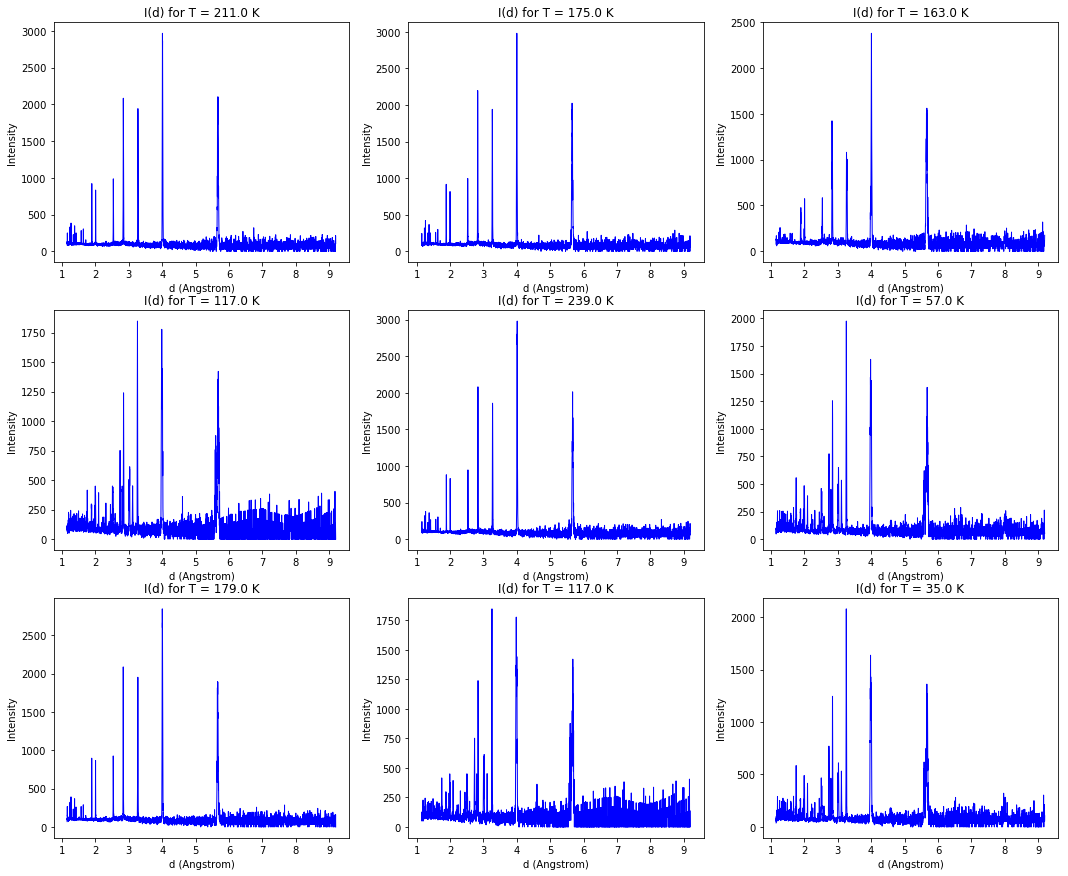

In [8]:
ncols = 3
nrows = 3
nfigs = ncols * nrows

fig = plt.figure(1, figsize=(6*ncols, 5*nrows))
for ifig in range(nfigs):
    itemp = np.random.randint(len(T))
    plt.subplot(nrows, ncols, ifig+1)
    plt.title('I(d) for T = {} K'.format(round(T[itemp]),2))
    plt.plot(ds,I[itemp], 'b', linewidth=1.0)
    plt.xlabel('d (Angstrom)')
    plt.ylabel('Intensity')
plt.show()

Here is the first I(d) curve:

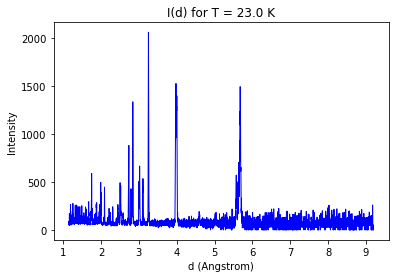

In [9]:
fig = plt.figure()
plt.title('I(d) for T = {} K'.format(round(T[0]),2))
plt.plot(ds, I[0], 'b', linewidth=1.)
plt.xlabel('d (Angstrom)')
plt.ylabel('Intensity')
plt.show()

## Q1 - Finding the Phase Transition Temperature:

"Provide an algorithm that given the data set as an input, provides the temperature of the structural transition."

The idea applied here is to locate the position of the peak with highest intensity for each value of temperature in the data set. During the phase transition, the position of this peak will change to a previously less intense peak.

Thus, by finding the temperature where the second most intense peak becomes the most intense, we can define where the phase transition occured.

Here is the array containing the maximum value of intensity for each temperature:

In [10]:
Imax = np.array([i.max() for i in I])

The array with the position of each one of these peaks:

In [11]:
dsmax = np.array([ds[np.argwhere(I[temp]==imax)].flatten()[0] for temp, imax in enumerate(Imax)])

Just out of interest, let's look how the distribution of Max I varies with temperature:

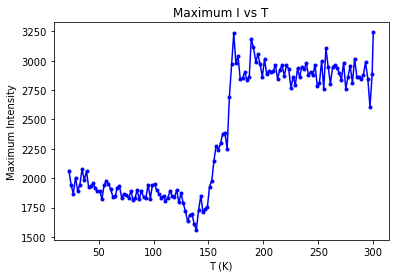

In [12]:
fig = plt.figure()
plt.title('Maximum I vs T')
plt.plot(T,Imax, 'b.-')
plt.xlabel('T (K)')
plt.ylabel('Maximum Intensity')
plt.show()

And the position of the maximum peak as a function of temperature:

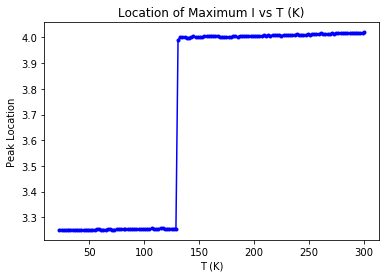

In [13]:
fig = plt.figure()
plt.title('Location of Maximum I vs T (K)')
plt.plot(T, dsmax, 'b.-')
plt.xlabel('T (K)')
plt.ylabel('Peak Location')
plt.show()

In [ ]:
popt, pcov = curve_fit(sigmoid_b, T, maxds, p0=[140, 3.2, 4.0])

In [ ]:
popt

In [ ]:
fig = plt.figure(figsize=(8,7))
plt.plot(T, maxds, 'k.:')
plt.plot(T, sigmoid2(T, *popt), 'r+:')
plt.show()

In [ ]:
T[np.argwhere(maxds>3.3)]

## Q2: Characterization of the 3.25 A Peak

Let's study the peak between 3.2 and 3.3 A for all temperatures. Namely, let's look at the center of the peak (d spacing coordinate), the area under the peak and a typical width.

Let's define a simple gausian function centered at 0 with unitary width. Also, a more general gausian with area A in the presence of uniform background b (visuals.py).

The Least Squared Errors function can be used to evaluate how well the data can be described by a gausian + b.

Let's concentrate in the (3.2,3.3) A region:

In [ ]:
def CharacterizePeaks(dsmin, dsmax):
    X = ds[np.argwhere((ds>dsmin)&(ds<dsmax))].flatten()
    Y = np.array([i[np.argwhere((ds>dsmin)&(ds<dsmax))].flatten() for i in I])

    AreaPeak = []
    MeanPeak = []
    WidthPeak = []
    MaxPeak = []
    BkgPeak = []
    LSEPeak = []

    for temp, y in enumerate(Y):
        area, mean, sigma = GetSeed(X, y)
        bkg, err = GetBkg(I[temp])
        popt, pcov = curve_fit(gaus_b, X, y, p0=[area, mean, sigma, bkg])
        A, x0, sigma, b = popt
        Yhat = np.array([gaus_b(x, A, x0, sigma, b) for x in X])
        res = Yhat - y
        AreaPeak.append(A)
        MeanPeak.append(x0)
        WidthPeak.append(sigma)
        MaxPeak.append(y.max())
        BkgPeak.append(b)
        LSEPeak.append(LSE(X, y, A, x0, sigma, b, err))

    AreaPeak = np.array(AreaPeak)
    MeanPeak = np.array(MeanPeak)
    WidthPeak = np.array(WidthPeak)
    MaxPeak = np.array(MaxPeak)
    BkgPeak = np.array(BkgPeak)
    LSEPeak = np.array(LSEPeak)
    return X, Y, AreaPeak, MeanPeak, WidthPeak, MaxPeak, BkgPeak, LSEPeak

In [ ]:
X, Y, AreaPeak, MeanPeak, WidthPeak, MaxPeak, BkgPeak, LSEPeak = CharacterizePeaks(3.2, 3.3)

After fitting a gausian+background to all 3.25 A peaks (for all temperatures), we can look at the distribution of area, center and width for these different temperatures:

In [ ]:
print(T[np.argmin(MaxPeak)])
print(T[np.argmax(WidthPeak)])

In [ ]:
peak = 3.25

fig = plt.figure(6, figsize=(12,18))

ax1 = plt.subplot(611)
plt.plot(T, AreaPeak, 'b.-', label='Area')
plt.legend()
plt.title('Area under the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Area under the {} A Peak'.format(peak))
plt.setp(ax1.get_xticklabels(), fontsize=10)

ax2 = plt.subplot(612, sharex=ax1)
plt.plot(T, MeanPeak, 'r.-', label='Mean')
plt.legend()
plt.title('Mean of the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Mean of the {} A Peak'.format(peak))

ax3 = plt.subplot(613, sharex=ax1)
plt.plot(T, WidthPeak, 'k.-', label='Width')
plt.legend()
plt.title('Width of the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Width of the {} A Peak'.format(peak))

ax3 = plt.subplot(614, sharex=ax1)
plt.plot(T, MaxPeak, '.-', label='Width')
plt.legend()
plt.title('Max Intensity Value of the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Max Intensity of the {} A Peak'.format(peak))

ax4 = plt.subplot(615, sharex=ax1)
plt.plot(T, BkgPeak, 'g.-', label='Background')
plt.legend()
plt.title('Background level around the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Background level around the {} A Peak'.format(peak))

ax5 = plt.subplot(616, sharex=ax1)
plt.plot(T, LSEPeak, 'y.-', label='LSE')
plt.legend()
plt.title('Least Squares for the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('LSE')

plt.tight_layout()
plt.show()

Let's normalize the data for visualization purposes:

In [ ]:
AreaNorm = Norm(AreaPeak)
MeanNorm = Norm(MeanPeak)
WidthNorm = Norm(WidthPeak)

In [ ]:
fig = plt.figure(3, figsize=(12,15))

ax1 = plt.subplot(311)
plt.plot(T, AreaNorm, 'b.-', label='Area')
plt.plot(T, MeanNorm, 'r.-', label='Mean')
plt.plot(T, WidthNorm, 'k.-', label='Width')
plt.legend()
plt.xlabel('Temperature (K)')
plt.show()

We can clearly see some interesting structure around T=150 K. Let's study this region more carefully:

In [ ]:
X, Y, AreaPeak, MeanPeak, WidthPeak, BkgPeak, LSEPeak = CharacterizePeaks(3.8, 4.2)

In [ ]:
peak = 4.

fig = plt.figure(5, figsize=(12,18))

ax1 = plt.subplot(511)
plt.plot(T, AreaPeak, 'b.-', label='Area')
plt.legend()
plt.title('Area under the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Area under the {} A Peak'.format(peak))
plt.setp(ax1.get_xticklabels(), fontsize=10)

ax2 = plt.subplot(512, sharex=ax1)
plt.plot(T, MeanPeak, 'r.-', label='Mean')
plt.legend()
plt.title('Mean of the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Mean of the {} A Peak'.format(peak))

ax3 = plt.subplot(513, sharex=ax1)
plt.plot(T, WidthPeak, 'k.-', label='Width')
plt.legend()
plt.title('Width of the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Width of the {} A Peak'.format(peak))

ax4 = plt.subplot(514, sharex=ax1)
plt.plot(T, BkgPeak, 'g.-', label='Background')
plt.legend()
plt.title('Background level around the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Background level around the {} A Peak'.format(peak))

ax5 = plt.subplot(515, sharex=ax1)
plt.plot(T, LSEPeak, 'y.-', label='LSE')
plt.legend()
plt.title('Least Squares for the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('LSE')

plt.tight_layout()
plt.show()

In [ ]:
phase = [i[0] for i in np.argwhere((T>149)&(T<151))]

In [ ]:
T[phase]

Let's look at the peak for values of T far and close to the transition:

In [ ]:
temp = 0

fig = plt.figure(2, figsize=(8,6))
ax1 = plt.subplot(211)
plt.plot(X, Y[temp], 'b.', label='T = {}'.format(round(T[temp], 1) ))
plt.legend()
plt.title('Intensity Curves')
frame = pylab.gca()
frame.axes.get_xaxis().set_ticks([])
plt.ylabel('Intensity')

temp = 64
ax2 = plt.subplot(212)
plt.plot(X, Y[temp], 'b.', label='T = {}'.format(round(T[temp], 1)))
plt.legend()
plt.xlabel('dspacing (A)')
plt.ylabel('Intensity')

plt.subplots_adjust(hspace=.003)

plt.show()

We can see how well the fit is doing by looking at the chi2 and residues:

In [ ]:
temp = [0, 30, 64, 100]
for itemp in temp:
    TestFit(X, Y[itemp], round(T[itemp], 1))

We can clearly see that the 3.25 A peak structure at $T = 150$ K does not look gausian at all. Therefore the fit fails ( chi2 and residues indicate a problem) and our fitted values for A, $\mu$ and $\sigma$ are not good. But since we are interested in finding a phase transition temperature we can still use the simple tools developed here so far. We can not trust the value for Area for example, but the value itslef is not important.

The important thing to keep in mind is how to find $T_{transition}$ !

Let's characterize one more peak, to see if we can detect a similar behaviour:

In [ ]:
X, Y, AreaPeak, MeanPeak, WidthPeak, BkgPeak, LSEPeak = CharacterizePeaks(5.5, 5.8)
peak = 5.6

fig = plt.figure(5, figsize=(12,18))

ax1 = plt.subplot(511)
plt.plot(T, AreaPeak, 'b.-', label='Area')
plt.legend()
plt.title('Area under the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Area under the {} A Peak'.format(peak))
plt.setp(ax1.get_xticklabels(), fontsize=10)

ax2 = plt.subplot(512, sharex=ax1)
plt.plot(T, MeanPeak, 'r.-', label='Mean')
plt.legend()
plt.title('Mean of the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Mean of the {} A Peak'.format(peak))

ax3 = plt.subplot(513, sharex=ax1)
plt.plot(T, WidthPeak, 'k.-', label='Width')
plt.legend()
plt.title('Width of the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Width of the {} A Peak'.format(peak))

ax4 = plt.subplot(514, sharex=ax1)
plt.plot(T, BkgPeak, 'g.-', label='Background')
plt.legend()
plt.title('Background level around the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('Background level around the {} A Peak'.format(peak))

ax5 = plt.subplot(515, sharex=ax1)
plt.plot(T, LSEPeak, 'y.-', label='LSE')
plt.legend()
plt.title('Least Squares for the {} A Peak vs Temperature (K)'.format(peak))
plt.xlabel('Temperature (K)')
plt.ylabel('LSE')

plt.tight_layout()
plt.show()

## Q3 Peak Detection

Given a temperature T, let's find all the Intensity peaks and characterize them. We find peaks by using the detect_peaks function [1] and characterize them with the gausian fit just like in Q2.

The GetPeaks function we are using is a simplified version of a matlab based peak detection algorithm [1].
This is one of the key parts of our algorithm. The way it works is basically we say that all points in the data are peaks, then we remove all of the points that are below some threshold (user input), and then we remove points that are too close to other peaks (user input).

The full algorithm can also look for valleys (by negating the data) and more complicated peak structure. But we have simplified the function since the data structure that we have is simpler.

[1] http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

In [ ]:
temp = 0
bkg, std = GetBkg(I[temp])
cut = int(bkg + 3.*std)
ind = GetPeaks(I[temp], mph=cut, mpd=65, show=True, scale=ds)

In [ ]:
temp = 64
bkg, std = GetBkg(I[temp])
cut = int(bkg + 3.*std)
ind = GetPeaks(I[temp], mph=cut, mpd=65, show=True, scale=ds)

In [ ]:
dsmin, dsmax = 5.5, 5.8

X = ds[np.argwhere((ds>dsmin)&(ds<dsmax))].flatten()
Y = np.array([i[np.argwhere((ds>dsmin)&(ds<dsmax))].flatten() for i in I])

temp = 0

fig = plt.figure(2, figsize=(8,6))
ax1 = plt.subplot(211)
plt.plot(X, Y[temp], 'b.', label='T = {}'.format(round(T[temp], 1) ))
plt.legend()
plt.title('Intensity Curves')
frame = pylab.gca()
frame.axes.get_xaxis().set_ticks([])
plt.ylabel('Intensity')

temp = 64
ax2 = plt.subplot(212)
plt.plot(X, Y[temp], 'b.', label='T = {}'.format(round(T[temp], 1)))
plt.legend()
plt.xlabel('dspacing (A)')
plt.ylabel('Intensity')

plt.subplots_adjust(hspace=.003)

plt.show()

Given that we have a way of finding all the peaks in the data for a certain T. We can characterize these peaks with the method used in Q2. Our pipeline is then:

In [ ]:
def Pipeline(temp=0, x=ds, show=False):
    # define the data set (x,y) for a given temperature T:
    y = I[temp]
    
    # Find all the Peaks and get the peak's positions:
    bkg, std = GetBkg(y)
    cut = int(bkg + 3.*std)
    inds = GetPeaks(y, mph=cut, mpd=65, show=show, scale=x)
    indsf = []
    for ind in inds:
        fine = True
        for iy in y[ind-10:ind+10]:
            if iy < 5: fine = False
        if fine: indsf.append(ind)
    inds = np.array(indsf)
    # Get all the interesting variables related to each peak:
    areas, means, sigmas, bkgs = GetVars(x, y, inds, bkg)
    npeaks = len(means)
    return npeaks, areas, means, sigmas, bkgs, inds

And we can get a list of all the peaks, including their centers, areas and widths with:

In [ ]:
temp = 0
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp)
imin, imax = inds[-2]-50, inds[-2]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, round(T[temp], 1))

In [ ]:
temp = 64
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp)
imin, imax = inds[-2]-50, inds[-2]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, round(T[temp], 1))

List of centers:

In [ ]:
means

## Q4 Phase Transition

The idea here will be to apply the method developed so far. We first detect all the peaks and characterize them for a given temperature T and also the adjacent neighbor.
Once we have a list of all the peaks (containing areas, centers and widths) we can compare both lists and check if a phase transition occured between these temperatures.

In [ ]:
temp = 0
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp, show=True)
imin, imax = inds[9]-50, inds[9]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, round(T[temp], 1))
imin, imax = inds[10]-50, inds[10]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, round(T[temp], 1))
imin, imax = inds[-1]-50, inds[-1]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, round(T[temp], 1))

In [ ]:
temp = 0
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp)
npeaks2, areas2, means2, sigmas2, bkgs2, inds2 =  Pipeline(temp=temp+1)

In [ ]:
means[1:] - means2

In [ ]:
temp = 64
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp)
npeaks2, areas2, means2, sigmas2, bkgs2, inds2 =  Pipeline(temp=temp+1)

In [ ]:
means

In [ ]:
means2

In [ ]:
imin, imax = inds[-1]-50, inds[-1]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, round(T[temp], 1))

In [ ]:
temp += 1
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, round(T[temp], 1))

In [ ]:
tic = time.time()
temp = 0
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp, show=False)
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp+1, show=False)
toc = time.time()
print(toc - tic)